In [2]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt

from scripts.utils import get_treatment_info, load_from_pickle

treatment_mapping_dict_simple = {
'bph':'BPH',
'untreated':'TRNA',
'goserelin':'NEADT',
'bicalutamide':'NEADT',
'degarelix':'NEADT',
'degarelix_apalutamide':'NEADT',
'crpc':'CRPC'}

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x4ke_r6f because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
pseudobulk_dat = pd.read_csv('data/spatial_pseudobulk_unnormalized.csv',index_col=0)
treat_info = get_treatment_info()

# Since the data has come through different pipelines, some genes might be present in only Tampere or only ARNEO
# Drop the genes that have 0 counts in either cohort
tampere_samples = pseudobulk_dat.columns[:37].tolist()
arneo_samples = pseudobulk_dat.columns[37:].tolist()
pseudobulk_dat = pseudobulk_dat[(pseudobulk_dat[tampere_samples].sum(axis=1) != 0) & (pseudobulk_dat[arneo_samples].sum(axis=1) != 0)]


### DESeq2 testing

In [ ]:
import anndata as ad
from pydeseq2 import dds
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

In [ ]:
# Transpose the data
pseudobulk_dat_T = pseudobulk_dat.T

# Add the treatment information
pseudobulk_dat_T['treatment'] = pseudobulk_dat_T.index.map(treat_info).map(treatment_mapping_dict_simple).tolist()

# Filter to contain only the treatnment-naive and the ADT treated
pseudobulk_dat_T =  pseudobulk_dat_T[pseudobulk_dat_T['treatment'].isin(['TRNA','NEADT'])]


In [ ]:
# Construct the DESeq2 dataset
pseudobulk_as_adata = ad.AnnData(pseudobulk_dat_T.drop(columns=['treatment']),
           var=pd.DataFrame(index=pseudobulk_dat_T.drop(columns=['treatment']).columns),
           obs=pseudobulk_dat_T[['treatment']]
           )

deseq_dataset = dds.DeseqDataSet(adata=pseudobulk_as_adata,design_factors='treatment', ref_level=['treatment','TRNA'])

# Run the DESeq2 analysis
deseq_dataset.deseq2()

In [ ]:
# Define the inference
inference = DefaultInference(n_cpus=2)

# Calculate the test statistics, lfc and p-values
stat_res = DeseqStats(deseq_dataset, inference=inference)
stat_res.summary()

# Get the final dataframe
de_res = stat_res.results_df.copy()

# Save the results into a csv file for later use
de_res.to_csv('./data/pseudobulk_deseq_res_trna_vs_neadt.csv')

### Read DESeq2 results from file

In [4]:
# Run this just to get the results
de_res = pd.read_csv('./data/pseudobulk_deseq_res_trna_vs_neadt.csv',index_col=0)
de_res = de_res.sort_values('log2FoldChange')
de_res_signif = de_res[(np.abs(de_res['log2FoldChange']) >=1) & (de_res['padj'] < 0.05)].sort_values('log2FoldChange') 
de_res_signif

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ANGPTL3,25.188908,-8.069311,2.943548,-2.741355,6.118632e-03,2.560462e-02
ORM2,220.073670,-5.828998,1.166864,-4.995437,5.870267e-07,1.952592e-05
PCGEM1,310.657000,-4.918171,1.135299,-4.332050,1.477273e-05,2.496724e-04
FGL1,22.119840,-4.744101,1.197179,-3.962735,7.409616e-05,8.772741e-04
AC026391.1,11.099131,-4.692907,1.248727,-3.758154,1.711717e-04,1.648450e-03
...,...,...,...,...,...,...
MYH7,35.879715,9.233259,1.946806,4.742773,2.108121e-06,5.380729e-05
AC245407.2,63.359120,9.244562,1.688024,5.476557,4.336810e-08,2.534534e-06
LIME1,267.253850,11.078207,1.851855,5.982221,2.201151e-09,2.472019e-07
DBNDD2,333.721900,11.118016,1.652017,6.729965,1.697037e-11,4.361152e-09


### TPM normalization and expression plotting

In [5]:
def extract_gene_lengths_from_gtf(file_path):
    gene_lengths = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            data = line.strip().split('\t')
            if data[2] == 'gene':
                attributes = data[8].split(';')
                gene_name = [x.split('"')[1] for x in attributes if 'gene_name' in x][0]
                start = int(data[3])
                end = int(data[4])
                length = end - start + 1
                gene_lengths[gene_name] = length

    return gene_lengths

# Specify the path to your GTF file
gtf_file_path = './gencode.v43.annotation.gtf'

# Extract gene lengths from the GTF file
gene_lengths = extract_gene_lengths_from_gtf(gtf_file_path)


In [6]:
# Subset the pseudobulk data to only contain those genes that have annotation
pseudobulk_dat = pseudobulk_dat[pseudobulk_dat.index.isin(gene_lengths.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = pseudobulk_dat.index.map(gene_lengths).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

In [7]:
# Function to calculate TPM
def calculate_tpm(df,gene_lengths_per_kb=gene_length_mapping):

    # Gene reads per kilobase
    df_rpk = df.divide(gene_lengths_per_kb,axis=0)

    # Total rpk per sample 
    sample_scaling_factor = df_rpk.sum()/1e6

    # TPM
    tpm_df = df_rpk.divide(sample_scaling_factor)

    return tpm_df

# Perform TPM normalization
tpm_normalized_dat = calculate_tpm(pseudobulk_dat)

In [8]:
# Modify the counts and subet categories

categories =['untreated','goserelin','bicalutamide', 'degarelix','degarelix_apalutamide']

# Add pseudocount and log2-transform
log2_tpm_normalized_dat = np.log2(tpm_normalized_dat.T +1 )

# Map treatment and filter according TRNA-NEADT
log2_tpm_normalized_dat['treatment'] = log2_tpm_normalized_dat.index.map(treat_info).map(treatment_mapping_dict_simple).tolist()
log2_tpm_normalized_dat['treatment_detailed'] = log2_tpm_normalized_dat.index.map(treat_info)




In [9]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240128.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

In [10]:
# Download the gene lists
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

In [36]:
de_res.loc['CCR2']

baseMean          49.651470
log2FoldChange     0.492751
lfcSE              0.269185
stat               1.830531
pvalue             0.067171
padj               0.156887
Name: CCR2, dtype: float64

In [56]:
deseq2_results_df = de_res_signif.copy()

marker_genes = check_top_markers('Club epithelium')['gene'].tolist()
#marker_genes = check_top_markers('Club epithelium')['gene'].tolist()
#gene_set = np.intersect1d(gene_set_df['MP19 Epithelial Senescence'].copy().tolist(),gene_set_df['Club'].copy().tolist())
#gene_set = gene_set_df['MP19 Epithelial Senescence'].copy().tolist()
#gene_set = gene_set_df['Luminal progenitor'].copy().tolist()
gene_set = gene_set_df['MP19 Epithelial Senescence'].copy().tolist()

# Genes that overlap between two signatures (e.g. EpiSen signatures and Club region markers) AND are DE-genes between TRNA and NEADT, 
gene_set = np.intersect1d(marker_genes,gene_set)
#gene_set = marker_genes.copy()


for g in deseq2_results_df.index.tolist():
    if g in gene_set:
        print(deseq2_results_df.loc[g,['baseMean','log2FoldChange','padj']])
        print('')
    #    print(g)

baseMean          1503.622000
log2FoldChange       1.159051
padj                 0.045753
Name: KRT7, dtype: float64

baseMean          2389.786400
log2FoldChange       1.268464
padj                 0.000087
Name: IGFBP3, dtype: float64

baseMean          589.561500
log2FoldChange      1.483273
padj                0.000205
Name: CRABP2, dtype: float64

baseMean          1330.151000
log2FoldChange       1.527407
padj                 0.005301
Name: SLPI, dtype: float64

baseMean          556.205570
log2FoldChange      2.370208
padj                0.040592
Name: KRT13, dtype: float64



### Plotting specific genes 

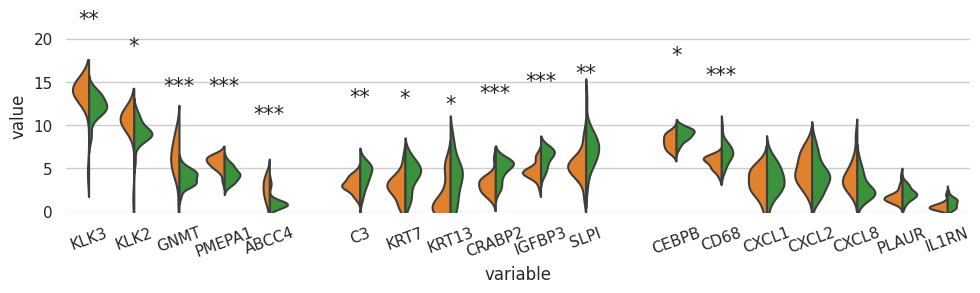

In [87]:
plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))

# Add dividers
plot_df[''] = np.nan
plot_df[' '] = np.nan
plot_df['  '] = np.nan

genes = [
    'KLK3','KLK2','GNMT','PMEPA1','ABCC4','',  #'NKX3-1' # AR
    #'CEACAM1','LCN2','LTF','C3', 'S100A8', 'S100A9','ANXA1',  ' ',  # CD300LD w/ club-region markers 
    'C3','KRT7','KRT13','CRABP2','IGFBP3','SLPI','  ', # EpiSen/club-region markers
    'CEBPB','CD68','CXCL1','CXCL2','CXCL8','PLAUR','IL1RN', # NLR-associated
    ]


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(10,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

plt.savefig('plots/pseudobulk_violin_AR_senescence_NLR_no_asterisks.pdf')

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    ymax = plot_df['value'].max() +2 - (8-vals.mean()) # What a formula :D 
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_AR_senescence_NLR.pdf')
plt.show()

In [82]:
[print(g) for g in genes]

KLK3
KLK2
GNMT
PMEPA1
ABCC4

KRT7
KRT13
CRABP2
IGFBP3
SLPI
  
CEBPB
CD68
CXCL1
CXCL2
CXCL8
PLAUR
IL1RN


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
he_2021_adata = sc.read_h5ad('./sc-reference/he_2021/adata.h5ad')

In [ ]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240128.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

In [ ]:
# Download the gene lists
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T
genes = gene_set_df['CD300LD downstream'].dropna().copy().tolist()

In [88]:
genes = [
    #'KLK3','KLK2','GNMT','PMEPA1','ABCC4',  #'NKX3-1' # AR
    #'KRT17','KRT19','KRT7','KRT13', #'WFDC2',# Experimental
    'KRT7','KRT13','CRABP2','IGFBP3','SLPI', # Overlap between EpiSen and Club markers
    #'CEBPB','CD68','CXCL1','CXCL2','CXCL8','PLAUR','IL1RN', # NLR-associated
    'C3','WFDC2','PIGR', 'S100A8','S100A9', 'PSCA','FABP5'# Experimental
    ]


NameError: name 'sc' is not defined

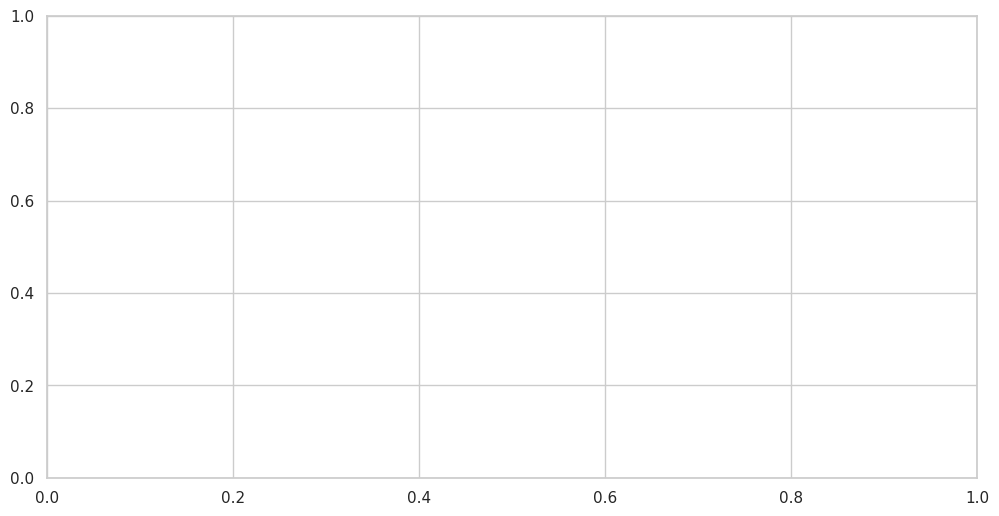

In [89]:
fig,ax = plt.subplots(figsize=(12,6))
sc.pl.dotplot(he_2021_adata,var_names=genes,groupby='group',ax=ax)

In [73]:
genes = [
    'KLK3','KLK2','GNMT','PMEPA1','ABCC4','',  #'NKX3-1' # AR
    'KRT7','KRT13','CRABP2','IGFBP3', 'SLPI',# EpiSen/club-region markers
    'C3','CEACAM1','LCN2','LTF','S100A8', 'S100A9','ANXA1',   # CD300LD w/ club-region markers 
    #'CEBPB','CD68','CXCL1','CXCL2','CXCL8','PLAUR','IL1RN', # NLR-associated
    ]

In [ ]:
genes = ['AGR2',
 'ANXA1',
 'AQP3',
 'C3',
 'CEACAM1',
 'CEACAM6',
 'CLDN4',
 'CLDN7',
 'CRABP2',
 'CXCL17',
 'ELF3',
 'GPRC5A',
 'IGFBP3',
 'KRT13',
 'KRT16',
 'KRT17',
 'KRT7',
 'LCN2',
 'LTF',
 'MAL2',
 'MUC4',
 'PDZK1IP1',
 'PI3',
 'PRSS22',
 'S100A8',
 'S100A9',
 'S100P',
 'SAA1',
 'SERPINB1',
 'SLPI',
 'TACSTD2',
 'WFDC2']

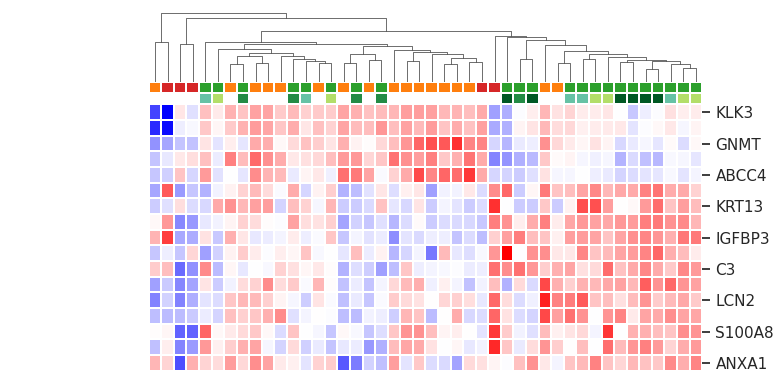

In [80]:
genes = [g for g in genes if g not in [' ', '','  ']]

plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT','CRPC'])].copy()

# Drop the all-stroma TUMOR
#plot_df = plot_df.drop(index='PC_05_13057_OIK_ANT_0')

plot_df = plot_df[genes+['treatment','treatment_detailed']]

col_colors1 = plot_df['treatment'].map({'TRNA':'#ff7f0e','NEADT':'#2ca02c','CRPC':'#d62728'})
col_colors2 = plot_df['treatment_detailed'].map({
    'untreated': '#FFFFFF',
    'crpc': '#FFFFFF',
    'bicalutamide': '#b3de69',  # Light green
    'goserelin': '#66c2a5',  # Medium green
    'degarelix': '#238b45',  # Dark green
    'degarelix_apalutamide': '#005824'  # Darkest green
}

)

#fig, ax = plt.subplots(figsize=(10,6))
h = sns.clustermap(
    plot_df.drop(columns=['treatment','treatment_detailed']).T,
               z_score=0,
               cmap='bwr',
               col_colors=[col_colors1,col_colors2],
               col_cluster=True,
               row_cluster=False,
               linewidth=0.2,
               figsize=(8,4),
               #square=True,
               xticklabels='',
               cbar_pos=None,
               #vmin=-2,
               #vmax=2
               )

plt.savefig('plots/pseudobulk_log2TPM_heatmap_AR_EpiSen_NLR.pdf')

In [77]:
[print(g) for g in plot_df.columns]

KLK3
KLK2
GNMT
PMEPA1
ABCC4
KRT7
KRT13
CRABP2
IGFBP3
SLPI
C3
CEACAM1
LCN2
LTF
S100A8
S100A9
ANXA1
treatment
treatment_detailed


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [365]:
plot_df.iloc[h.dendrogram_col.reordered_ind]

,KLK3,KLK2,GNMT,PMEPA1,ABCC4,KRT7,KRT13,CRABP2,IGFBP3,SLPI,CEBPB,CD68,CXCL1,CXCL2,CXCL8,PLAUR,IL1RN,treatment,treatment_detailed
PC_04_12646_VAS,14.845178,10.601926,8.289581,5.877347,4.321590,3.466880,2.853426,3.471013,4.262343,5.203237,9.296541,6.262571,5.869011,6.877482,8.751390,4.115459,1.982544,TRNA,untreated
P32043,11.187619,8.739280,3.315347,3.281087,0.335834,1.513579,0.000000,3.776635,7.463658,5.530888,9.077806,7.215508,3.301156,4.064790,1.642743,1.806679,0.550480,NEADT,degarelix
P32044,11.927384,9.243950,3.415108,3.411611,0.668194,3.026641,0.000000,5.235448,6.246024,8.708710,9.330893,9.782612,0.000000,2.779583,2.175439,2.261503,0.888190,NEADT,degarelix_apalutamide
P32014,8.343056,5.815433,1.814583,2.856103,0.470009,6.689396,1.844691,5.807242,6.820717,13.058628,9.262916,6.984716,5.264378,4.945146,2.098368,2.413687,1.343466,NEADT,degarelix_apalutamide
P32062,11.258832,9.096843,2.817302,3.323108,0.448174,5.033846,1.848737,5.681481,6.721571,8.237729,9.689247,8.059255,2.841887,3.657426,1.618216,1.844423,0.915073,NEADT,degarelix_apalutamide
P32036,9.255267,7.475530,3.324566,3.896184,0.585579,4.972617,2.123391,5.558925,7.124624,8.439994,9.384645,7.754338,4.040383,3.674284,2.435372,1.851683,0.582789,NEADT,degarelix_apalutamide
PC_05_24402_OIK_ANT2_1,11.938131,8.092278,2.930548,4.313380,0.738299,5.008753,5.399421,5.951548,7.582965,7.475728,9.552521,7.375524,4.310446,4.349685,4.136954,3.387213,1.633814,NEADT,bicalutamide
P32041,10.690081,8.251378,3.645575,3.499270,0.736633,6.028025,5.523266,6.222897,7.320466,9.131011,9.896714,7.949686,5.447755,4.340656,3.425404,2.887471,1.420152,NEADT,degarelix_apalutamide
P32084,11.213712,8.609057,3.204559,3.389182,0.778865,6.380679,7.154691,6.315995,7.008063,9.971974,9.289316,7.857972,4.230219,4.068927,1.720742,2.154857,1.439359,NEADT,degarelix_apalutamide
PC_06_03093_OIK_ANT_1,11.964103,8.733930,4.127744,4.063232,1.002449,3.977928,4.334744,5.002706,7.551261,6.107346,9.384804,7.037111,5.434867,6.059348,5.231280,2.962362,1.399274,NEADT,bicalutamide


log2FoldChange    0.384530
padj              0.786529
Name: CXCR2, dtype: float64


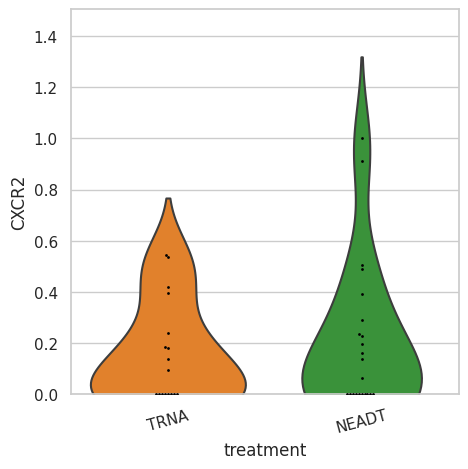

In [134]:
plot_df = log2_tpm_normalized_dat.copy()
cat_to_use = 'treatment'
#cat_to_use = 'treatment_detailed'


#genes = de_res_signif[-20:].index.tolist()
genes = ['CXCR2']


for gene in genes:
    if gene in plot_df.columns:


        fig, ax = plt.subplots(figsize=(5,5))

        sns.swarmplot(plot_df,x=cat_to_use,y=gene,ax = ax,color='black',size=2)

        #sns.violinplot(plot_df,x='treatment',y=gene,ax = ax,inner='box')
        sns.violinplot(plot_df,x=cat_to_use,y=gene,ax = ax,inner=None)

        ax.set_ylim(0,plot_df[gene].max() + plot_df[gene].max()/2)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

        print(de_res.loc[gene,['log2FoldChange','padj']])
        
        plt.show()

In [330]:
genes = (
        gene_set_df['AR signaling'].copy().tolist() +
        gene_set_df['CRPC-SCL'].copy().tolist()
        #list(np.intersect1d(gene_set_df['CRPC-SCL'].copy().tolist(),gene_set_df['Club'].copy().tolist()))
          
          )

genes = [g for g in genes if g in plot_df.columns.tolist()]